# TP : Fuzzy C-Means - Segmentation d'image
## Master 2 Informatique - VMI

**Objectif :** Implémenter et appliquer l'algorithme de Fuzzy C-Means à la segmentation d'images en niveau de gris.

Import des libs nécessaires

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

print("ok")

ok


Chargement de l'image

In [2]:
def load_image(path):
    img = Image.open(path).convert('RGB')
    img = np.array(img, dtype=np.uint8)
    return img

image_path = "milky-way.jpg"  # milky-way-nvg.jpg

img = load_image(image_path)

# traitement different selon si l'image est en niveaux de gris ou en couleur
if img.ndim == 2:
    pixels = img.reshape(-1, 1).astype(np.float32)
else:
    pixels = img.reshape(-1, img.shape[2]).astype(np.float32)

# normalisation
scaler = MinMaxScaler()
pixels = scaler.fit_transform(pixels)

print("Image chargée, shape:", img.shape)
print("Nombre de pixels:", pixels.shape[0])

Image chargée, shape: (1024, 1024, 3)
Nombre de pixels: 1048576


Implementation de Fuzzy C-Means

Formules du cours:
- centres: c_j = sum(u_ij^m * x_i) / sum(u_ij^m)
- appartenance: u_ij = 1 / sum((d_ij/d_ik)^(2/(m-1)))

In [3]:
# init random des appartenances
def init_U(n_pixels, n_clusters):
    # dirichlet pour que la somme fasse 1
    U = np.random.dirichlet(np.ones(n_clusters), size=n_pixels)
    return U

def calc_centres(U, X, m):
    um = U ** m 
    centres = (um.T @ X) / np.sum(um.T, axis=1, keepdims=True)
    return centres

def maj_U(U, X, centres, m):
    c = len(centres)
    n = X.shape[0]
    
    distances = np.zeros((n, c))
    for j in range(c):
        diff = X - centres[j]
        distances[:, j] = np.sqrt(np.sum(diff**2, axis=1))  # d euclidienne
    
    # eviter div par 0
    distances = np.fmax(distances, 1e-8)
    
    # formule du pdf
    exposant = 2.0 / (m - 1)
    U_new = np.zeros((n, c))
    
    for i in range(n):
        for j in range(c):
            somme = 0
            for k in range(c):
                somme += (distances[i,j] / distances[i,k]) ** exposant
            U_new[i,j] = 1.0 / somme
    
    return U_new

# algo principal
def fuzzy_cmeans(X, nb_clusters=2, m=2.0, epsilon=1e-5, max_iter=100):
    n = X.shape[0]
    
    U = init_U(n, nb_clusters)
    
    for iteration in range(max_iter):
        U_ancien = U.copy()
        
        # etape 1: calcul centres
        centres = calc_centres(U, X, m)
        
        # etape 2: maj U
        U = maj_U(U, X, centres, m)
        
        # critere convergence
        diff = np.linalg.norm(U - U_ancien)
        if diff < epsilon:
            print(f"Convergence atteinte apres {iteration+1} iterations")
            break
    
    return centres, U

print("Fonctions définies")

Fonctions définies


Application sur l'image

In [4]:
# param
nb_clusters = 2  # segmentation binaire
m = 2.0  # parametre de flou

print("Debut du clustering...")
centres, U = fuzzy_cmeans(pixels, nb_clusters=nb_clusters, m=m)

# pour chaque pixel, on prend le cluster avec la plus forte appartenance
labels = np.argmax(U, axis=1)

# degre d'appartenance max pour chaque pixel
degre_appartenance = np.max(U, axis=1)

# reshape pour retrouver la forme de l'image
h, w = img.shape[0], img.shape[1]
img_segmentee = labels.reshape(h, w)
carte_appartenance = degre_appartenance.reshape(h, w)

print("Terminé!")
print("Centres trouvés:")
print(centres)

Debut du clustering...
Convergence atteinte apres 30 iterations
Terminé!
Centres trouvés:
[[0.46765894 0.42749688 0.47267714]
 [0.09357933 0.10673454 0.14353474]]


Affichage des résultats

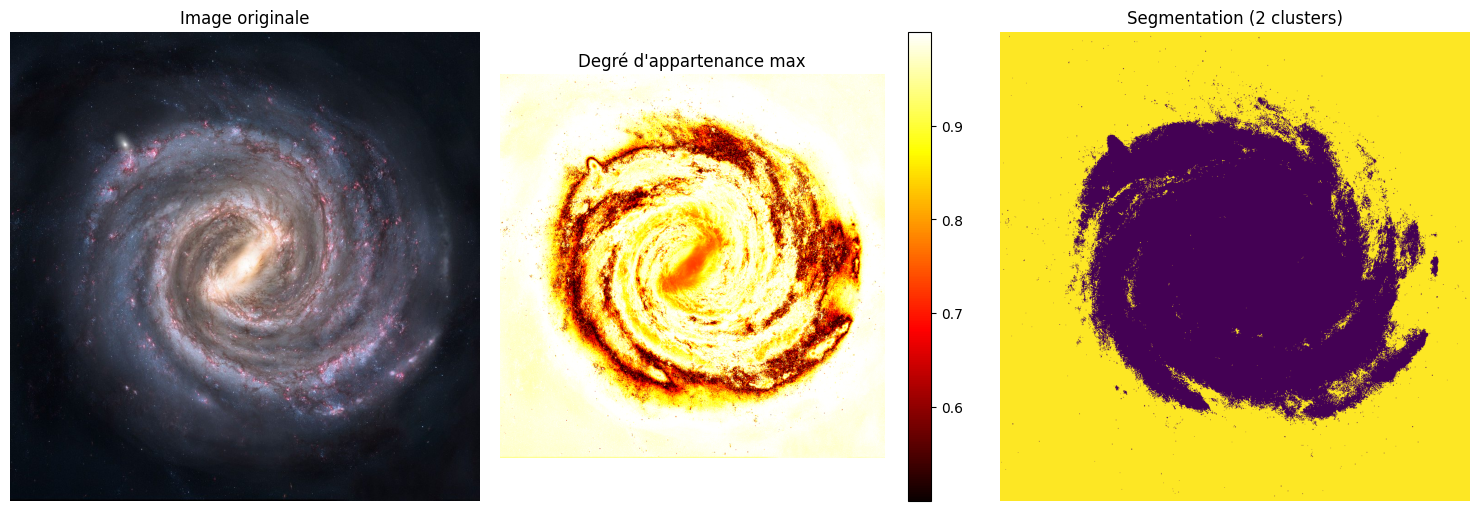

In [5]:
fig = plt.figure(figsize=(15, 5))

# image originale
plt.subplot(1, 3, 1)
plt.title("Image originale")
plt.imshow(img)
plt.axis('off')

# carte d'appartenance
plt.subplot(1, 3, 2)
plt.title("Degré d'appartenance max")
plt.imshow(carte_appartenance, cmap='hot')
plt.colorbar()
plt.axis('off')

# segmentation finale
plt.subplot(1, 3, 3)
plt.title(f"Segmentation ({nb_clusters} clusters)")
plt.imshow(img_segmentee, cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()

Test avec plus de clusters

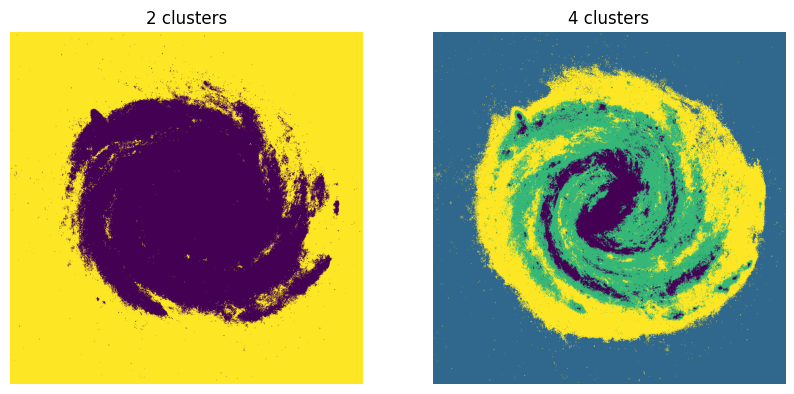

In [ ]:
# essai avec 4 clusters
centres2, U2 = fuzzy_cmeans(pixels, nb_clusters=4, m=2.0)
labels2 = np.argmax(U2, axis=1)
img_seg2 = labels2.reshape(h, w)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("2 clusters")
plt.imshow(img_segmentee, cmap='viridis')
plt.axis('off')


plt.subplot(1, 2, 2)
plt.title("4 clusters") # plus de 15 min wow
plt.imshow(img_seg2, cmap='viridis')
plt.axis('off')

plt.show()